TO READ: https://drive.google.com/file/d/1cr8vYmjvbVp4iS6KwhNQBn9Nkb3ylVjK/view

In [1]:
import datetime
import os
import re
import urllib
import sys
import math
import numpy as np
import pandas as pd
from scipy.stats import describe

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import matplotlib.ticker as ticker
%matplotlib inline

from wordcloud import WordCloud
import networkx as nx
from gensim.models import KeyedVectors

c:\users\thomas\hpi\textmi~1\venv\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Data files

# article_id, article_url
SRC_ARTICLES = '../data/guardian-all/articles-standardized.csv'
SRC_AUTHORS = '../data/guardian-all/authors-standardized.csv'
SRC_COMMENTS = '../data/guardian-all/sorted_comments-standardized.csv'
SRC_COMMENTS_POL = '../data/pol/comments-root-all-pol.csv'
SRC_COMMENTS_POL_ALL = '../data/pol/comments-all-pol.csv'
SRC_COMMENTS_TOKENIZED_BIN = '../data/embedding/gensim-guardian-comments-50-tokenized.bin'

OUTPUT_DIR = './week-5-plots'

def plot_timestamps(article_id):
    datetimes = data[data['article_id'] == article_id]['timestamp']
    timestamps = [int(datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ").timestamp()) for x in datetimes]
    plt.hist(timestamps)

In [3]:
data_comments_pol = pd.read_csv(SRC_COMMENTS_POL_ALL)

In [4]:
article_ids = data_comments_pol['article_id'].unique()  # 20140 ids

In [5]:
data_articles = pd.read_csv(SRC_ARTICLES)  # shape = (626395, 2)
data_articles_pol = data_articles[data_articles['article_url'].str.contains('/politics/')]  # shape = (20167, 2)
data_authors = pd.read_csv(SRC_AUTHORS)
data_comments_pol = pd.read_csv(SRC_COMMENTS_POL_ALL)

article_ids = data_comments_pol['article_id'].unique()  # 2876 ids

In [6]:
pattern = re.compile(r'\.com\/([^\/]*)\/([^\/]*)\/')
pattern2 = re.compile(r'\.com\/([^\/]*)')

def get_category(link):
    m = pattern.search(link)
    if not m:
        m = pattern2.search(link)
        return m.group(1)
    return m.group(1)

links = data_articles['article_url'].values
categories = [get_category(x) for x in links]
uniques = np.unique(categories)
# np.set_printoptions(threshold=np.inf)
# print(uniques)

In [7]:
upvotes_per_author = data_comments_pol[['author_id', 'upvotes']].groupby('author_id').sum().iloc[:, 0]
comments_per_author = data_comments_pol[['author_id', 'upvotes']].groupby('author_id').count().iloc[:, 0]
mean_upvotes_per_author = upvotes_per_author / comments_per_author

In [9]:
replies_count = pd.Series(index=data_comments_pol['comment_id'], data=0)
parent_comment_ids = data_comments_pol['parent_comment_id']
for parent_id in parent_comment_ids[~parent_comment_ids.isnull()].values:
    if parent_id in replies_count:
        replies_count.loc[parent_id] += 1

In [10]:
print('row:', data_comments_pol['upvotes'].values.argmax())
print('upvotes:', data_comments_pol['upvotes'].max())
print('author_id:', data_comments_pol.iloc[3197]['author_id'])

row: 1664592
upvotes: 2615
author_id: 54083


In [11]:
extracted_features = dict()
extracted_features['upvotes'] = data_comments_pol['upvotes'].values
extracted_features['replies'] = replies_count.loc[data_comments_pol['comment_id']].values
extracted_features['text_length'] = data_comments_pol['comment_text'].str.len().values
extracted_features['author_upvotes'] = upvotes_per_author.loc[data_comments_pol['author_id']].values
extracted_features['author_comments'] = comments_per_author.loc[data_comments_pol['author_id']].values
extracted_features['mean_author_upvotes'] = mean_upvotes_per_author.loc[data_comments_pol['author_id']].values
extracted_features['rank'] = data_comments_pol.groupby('article_id')['timestamp'].rank(method='dense').astype(int)
extracted_features['total_upvotes'] = data_comments_pol.groupby('article_id')['upvotes'].transform('sum')
extracted_features['total_comments'] = data_comments_pol.groupby('article_id')['upvotes'].transform('count')
extracted_features['parent_comment_id'] = data_comments_pol['parent_comment_id'].values
# extracted_features['rel_upvotes'] = extracted_features.apply(lambda row: (row.upvotes / (row.total_upvotes or 1)) * 100, axis=1)

# TODO:
# Rang
# Rechtschreibung (cluster words?)
# Amount of words
# Mean amount of words in a sentence
# Grammatik (use pretrained model)
# TODO: normalize upvotes
# Ähnlichkeit von Comment and Article (used words from articles wordcloud)

In [12]:
extracted_features['rel_upvotes'] = [
        (upvotes / (total_upvotes or 1)) * 100
        for upvotes, total_upvotes
        in zip(extracted_features['upvotes'], extracted_features['total_upvotes'])
    ]

In [13]:
# 1. Neues Embedding
# 2. Use Normalization
# 3. Neues Setting
# 4. Feature Extraction
# 5. Only consider first comment with zero upvotes and hundredth comment with more than zero upvotes
# 6. Filter mediocre comments. Try to analyse really bad and really good comments

In [36]:
extracted_features_df = pd.DataFrame.from_dict(extracted_features)
# extracted_features_df['rel_upvotes'] = extracted_features_df.apply(lambda row: (row.upvotes / (row.total_upvotes or 1)) * 100, axis=1)

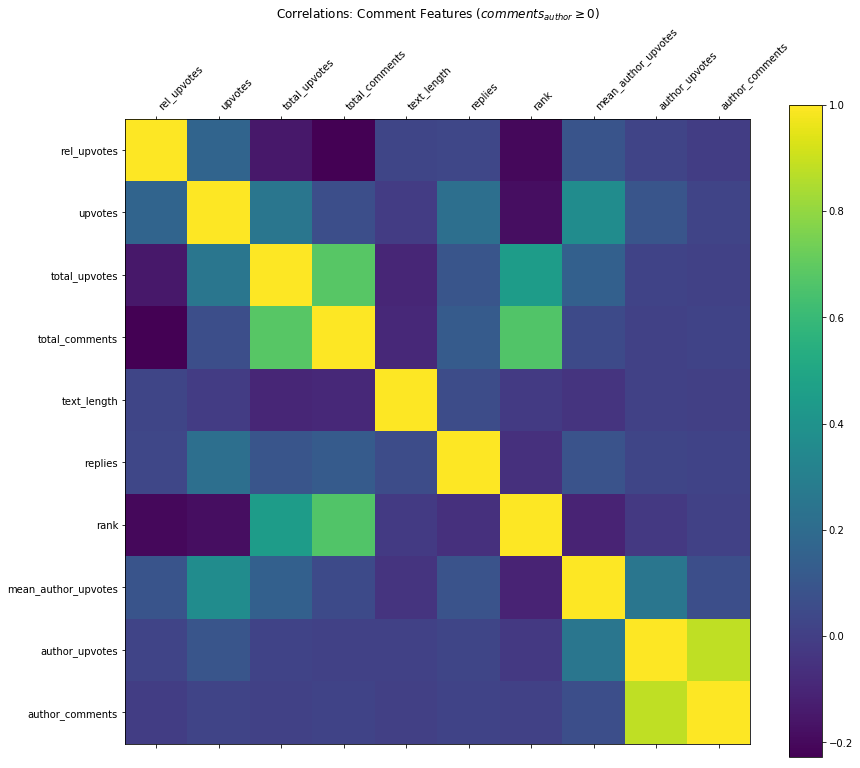

In [39]:
author_comments = 0

labels = list(reversed(extracted_features_df.columns))
labels.remove('parent_comment_id')
labels.remove('rel_upvotes')
labels.remove('upvotes')
labels = ['rel_upvotes', 'upvotes'] + labels

fig, ax = plt.subplots(1, 1, figsize=(14, 12))
cax = ax.matshow(extracted_features_df[extracted_features_df['author_comments'] > author_comments][labels].corr())
cbar = fig.colorbar(cax)
ax.set_xticklabels([''] + labels, rotation=45, ha='left')
ax.set_yticklabels([''] + labels)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_title(rf'Correlations: Comment Features ($comments_{{author}} \geq {author_comments}$)', y=1.15)
fig.savefig(f'correlations-{author_comments}.pdf')
# fig.savefig('comments_from_1000er_authors.png')

In [17]:
# class for top 10 comments (not equal distributed classes)
# classweights for loss functions (weights per class)
# otherwise over oder under sampling

### Data augmentation translate german to english and vice versa

In [ ]:
plt.scatter(extracted_features_df['text_length'], extracted_features_df['rel_upvotes'])
plt.savefig('scatter-text-len-rel-upvotes.pdf')

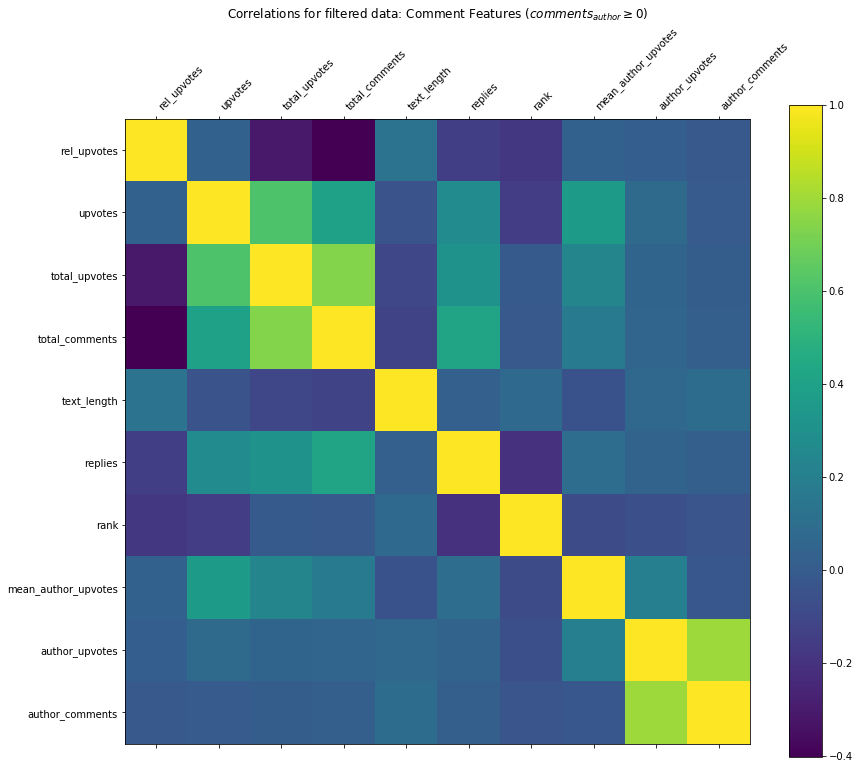

In [38]:
labels = list(reversed(extracted_features_df.columns))
labels.remove('parent_comment_id')
labels.remove('rel_upvotes')
labels.remove('upvotes')
labels = ['rel_upvotes', 'upvotes'] + labels

filtered_df = extracted_features_df[extracted_features_df['parent_comment_id'].isnull()]
filtered_df = filtered_df[filtered_df['rank'] <= 10] # select only first 10 comments
filtered_df = filtered_df[filtered_df['total_upvotes'] > 20] # do not consider articles with under 10 upvotes
# filtered_df = filtered_df[filtered_df['comment_text'].str.len() > 50]
filtered_df = filtered_df[filtered_df['total_comments'] > 10] # remove articles with over under 10 comments.

fig, ax = plt.subplots(1, 1, figsize=(14, 12))
cax = ax.matshow(filtered_df[labels].corr())
cbar = fig.colorbar(cax)
ax.set_xticklabels([''] + labels, rotation=45, ha='left')
ax.set_yticklabels([''] + labels)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_title(rf'Correlations for filtered data: Comment Features ($comments_{{author}} \geq {author_comments}$)', y=1.15)
fig.savefig(f'correlations-filtered-{author_comments}.pdf')
# fig.savefig('comments_from_1000er_authors.png')

In [ ]:
print('Filtered: {len(filtered_df)} out pf {len(extracted_features_df)}')

In [ ]:
plt.scatter(filtered_df['text_length'], filtered_df['rel_upvotes'])
plt.savefig('scatter-filtered-text-len-rel-upvotes.pdf')